In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Opcjonalnie Bayesian Optimization
import keras_tuner as kt

C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/resource_handle.proto

In [23]:
df = pd.read_csv('data/SuperMarket Analysis.csv')
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


In [24]:
df['UnitPriceLog'] = np.log1p(df['Unit price'])

df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

df.drop(['Date', 'Time', 'Invoice ID'], axis=1, inplace=True)

C:\Users\mateuszlamla\AppData\Local\Temp\ipykernel_20312\1321478894.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


In [28]:
# df_encoded = pd.get_dummies(df, drop_first=True)
# df_encoded.head()

columns_to_encode = ['Branch', 'City', 'Customer type','Gender', 'Product line', 'Payment']

for col in columns_to_encode:
    unique_vals = df[col].unique()
    mapping = {val: i+1 for i, val in enumerate(unique_vals)}
    df[col + '_id'] = df[col].map(mapping)
df.drop(columns_to_encode, axis=1, inplace=True)



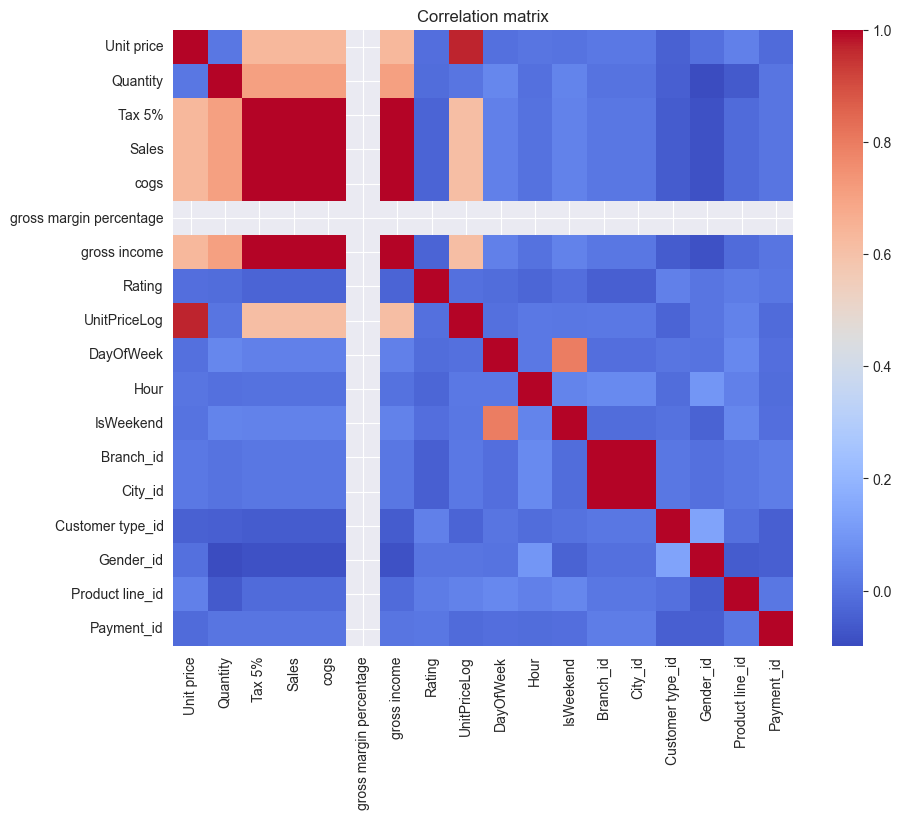

In [29]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()

In [30]:
X = df.drop('UnitPriceLog', axis=1)
Y = df['UnitPriceLog']

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [32]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1,1))
Y_test_scaled  = scaler_Y.transform(Y_test.values.reshape(-1,1))

In [63]:
def build_stable_model(input_dim):
    # model = Sequential()
    #
    # # Warstwa ukryta 1
    # model.add(layers.Dense(64, activation='relu',
    #                        input_shape=(input_dim,),
    #                        kernel_regularizer=regularizers.l2(0.001)))
    # model.add(layers.BatchNormalization())
    # model.add(layers.Dropout(0.5))
    #
    # # Warstwa ukryta 2
    # model.add(layers.Dense(32, activation='relu',
    #                        kernel_regularizer=regularizers.l2(0.001)))
    # model.add(layers.BatchNormalization())
    # model.add(layers.Dropout(0.4))
    #
    # # Wyjście
    # model.add(layers.Dense(1, activation='linear'))
    #
    # model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        model = Sequential()

        # Warstwa ukryta 1
        model.add(layers.Dense(96, activation='relu',
                               input_shape=(input_dim,),
                               kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.4))

        # Warstwa ukryta 2
        model.add(layers.Dense(96, activation='relu',
                               kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.2))

        # Wyjście
        model.add(layers.Dense(1, activation='linear'))

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

input_dim = X_train_scaled.shape[1]
model = build_stable_model(input_dim)

# EarlyStopping
es = EarlyStopping(patience=15, restore_best_weights=True)

# Trening
history = model.fit(
    X_train_scaled, Y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/200


C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8939 - mae: 1.0399 - val_loss: 0.4179 - val_mae: 0.4826
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1503 - mae: 0.8004 - val_loss: 0.2557 - val_mae: 0.3196
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8987 - mae: 0.6966 - val_loss: 0.1950 - val_mae: 0.2380
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7844 - mae: 0.6455 - val_loss: 0.1809 - val_mae: 0.2127
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6390 - mae: 0.5663 - val_loss: 0.1794 - val_mae: 0.2041
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6010 - mae: 0.5443 - val_loss: 0.1704 - val_mae: 0.1792
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5480 - mae: 0.5088 - val_loss: 0.1707 - val_mae: 0.1813
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5178 - mae: 0.4971 - val_loss: 0.1711 - val_mae: 0.1794
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4642 - mae: 0.4

In [61]:
Y_pred_scaled = model.predict(X_test_scaled).flatten()
Y_pred = np.expm1(scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1,1))).flatten()
Y_actual = np.expm1(scaler_Y.inverse_transform(Y_test_scaled.reshape(-1,1))).flatten()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [62]:
mae = mean_absolute_error(Y_actual, Y_pred)
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_actual, Y_pred)

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")

ValueError: Found input variables with inconsistent numbers of samples: [200, 6400]

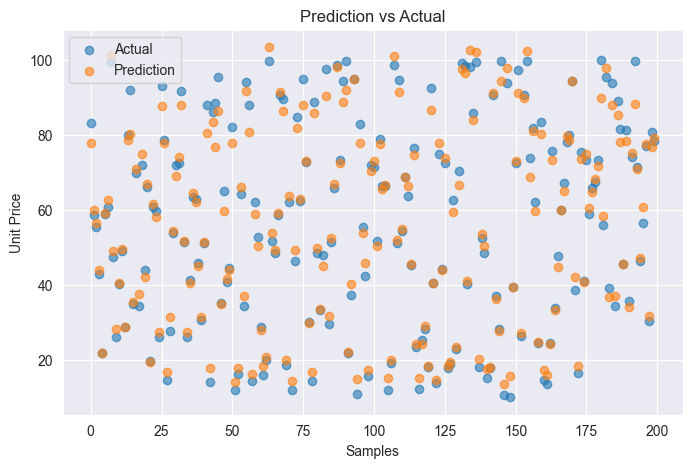

In [57]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(Y_actual)), Y_actual, label="Actual", alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, label="Prediction", alpha=0.6)
plt.xlabel("Samples")
plt.ylabel("Unit Price")
plt.title("Prediction vs Actual")
plt.legend()
plt.show()

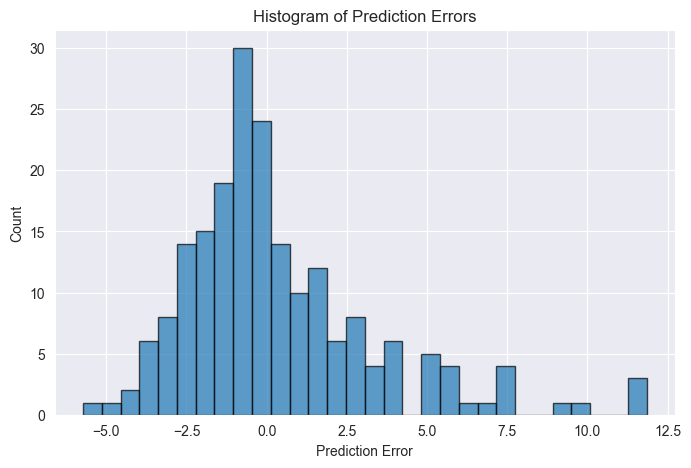

In [58]:
errors = Y_actual - Y_pred
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Histogram of Prediction Errors")
plt.show()

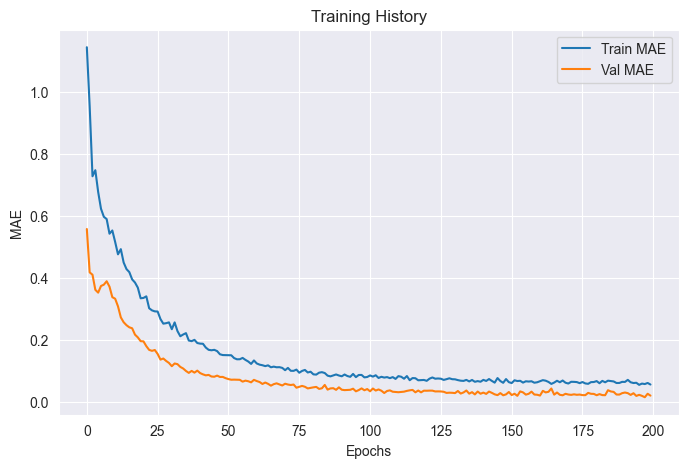

In [59]:
plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training History")
plt.legend()
plt.show()

In [39]:
def build_model_tuner(hp):
    model = Sequential()
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(
            units=hp.Int("units_" + str(i), 16, 128, step=16),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float("dropout_" + str(i), 0.0, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))

    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse', metrics=['mae'])
    return model

In [40]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model_tuner,
    objective='val_mae',
    max_trials=20,
    directory='tuner_dir',
    project_name='supermarket_price'
)

Reloading Tuner from tuner_dir\supermarket_price\tuner0.json


In [41]:
tuner.search(
    X_train_scaled,
    Y_train_scaled,
    validation_split=0.2,
    epochs=50,
    callbacks=[EarlyStopping(patience=5)]
)

In [42]:
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)


{'num_layers': 2, 'units_0': 96, 'dropout_0': 0.4, 'learning_rate': 0.001, 'units_1': 96, 'dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.0}


C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
